In [1]:
# Import necessary libraries
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import cv2
from google.colab import drive
# from pytorch_grad_cam import GradCAM
# from pytorch_grad_cam.utils.image import show_cam_on_image

# Mount Google Drive
drive.mount('/content/drive')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define paths
csv_path =  '/content/drive/MyDrive/Tmdb_posters_custom/undersampled_movie_metadata.csv'
# poster_folder = os.path.join(base_dataset_dir, 'movie_posters')

Mounted at /content/drive
Using device: cuda


In [2]:
import os
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm


data = pd.read_csv(csv_path)

# Convert genres from string to list (e.g., "['Action', 'Adventure']" -> ['Action', 'Adventure'])
data['genres'] = data['genres'].apply(eval)

# Create local directory for posters in Colab runtime
local_poster_dir = '/content/posters'
os.makedirs(local_poster_dir, exist_ok=True)

# Function to download posters
def download_poster(poster_path, movie_id):
    url = f"https://image.tmdb.org/t/p/w500{poster_path}"
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content))
            local_path = os.path.join(local_poster_dir, f"{movie_id}.jpg")
            img.save(local_path)
            return local_path
    except Exception as e:
        print(f"Error downloading {url}: {e}")
    return None

# Download posters with progress bar
tqdm.pandas()
data['local_poster_path'] = data.progress_apply(lambda row: download_poster(row['poster_path'], row['movie_id']), axis=1)

100%|██████████| 20506/20506 [18:38<00:00, 18.33it/s]


In [3]:
print(local_poster_dir)

/content/posters


In [4]:
# Drop rows where poster download failed
data = data.dropna(subset=['local_poster_path'])
print(f"After dropping failed downloads, dataset size: {len(data)}")

# Define valid genres
valid_genres = ['Drama', 'Comedy', 'Documentary', 'Romance', 'Action', 'Thriller',
                'Horror', 'Crime', 'Music', 'Animation', 'TV Movie', 'Family']
data['genres'] = data['genres'].apply(lambda x: [g for g in x if g in valid_genres])

# One-hot encode genres
mlb = MultiLabelBinarizer(classes=valid_genres)
genre_labels = mlb.fit_transform(data['genres'])
genre_df = pd.DataFrame(genre_labels, columns=mlb.classes_)
data = data.reset_index(drop=True)
data = pd.concat([data[['local_poster_path', 'genres', 'movie_id']], genre_df], axis=1)

# Split data
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")
print(f"Genre distribution:\n{train_df[mlb.classes_].mean()}")

# Check for data leakage
assert len(set(train_df['movie_id']).intersection(set(val_df['movie_id']))) == 0, "Data leakage detected!"

After dropping failed downloads, dataset size: 20506
Training samples: 16404, Validation samples: 4102
Genre distribution:
Drama          0.245428
Comedy         0.230919
Documentary    0.181297
Romance        0.155633
Action         0.191904
Thriller       0.200073
Horror         0.154231
Crime          0.127530
Music          0.124970
Animation      0.143197
TV Movie       0.124726
Family         0.142709
dtype: float64


In [5]:
# Optimized data augmentation
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# Custom Dataset
class MoviePosterDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.genre_columns = list(mlb.classes_)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['local_poster_path']
        image = Image.open(img_path).convert('RGB')
        labels = self.dataframe.iloc[idx][self.genre_columns].values.astype('float32')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(labels)

In [7]:
# Data loaders
train_dataset = MoviePosterDataset(train_df, transform=train_transform)
val_dataset = MoviePosterDataset(val_df, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

Model moved to cuda
Epoch 1/20, Train Loss: 1.0211, Val Loss: 0.9490, Train Accuracy: 0.7693, Val Accuracy: 0.7817
Epoch 2/20, Train Loss: 0.9470, Val Loss: 0.9402, Train Accuracy: 0.7869, Val Accuracy: 0.7938
Epoch 3/20, Train Loss: 0.9104, Val Loss: 0.9199, Train Accuracy: 0.7944, Val Accuracy: 0.7891
Epoch 4/20, Train Loss: 0.8713, Val Loss: 0.9150, Train Accuracy: 0.8017, Val Accuracy: 0.7995
Epoch 5/20, Train Loss: 0.8417, Val Loss: 0.9219, Train Accuracy: 0.8085, Val Accuracy: 0.8020
Epoch 6/20, Train Loss: 0.8050, Val Loss: 0.9213, Train Accuracy: 0.8170, Val Accuracy: 0.7876
Epoch 7/20, Train Loss: 0.7643, Val Loss: 0.9495, Train Accuracy: 0.8241, Val Accuracy: 0.7952
Epoch 8/20, Train Loss: 0.7213, Val Loss: 0.9757, Train Accuracy: 0.8349, Val Accuracy: 0.8017
Epoch 9/20, Train Loss: 0.6642, Val Loss: 0.9890, Train Accuracy: 0.8469, Val Accuracy: 0.7957
Epoch 10/20, Train Loss: 0.6119, Val Loss: 1.0581, Train Accuracy: 0.8581, Val Accuracy: 0.8030
Epoch 11/20, Train Loss: 0.55

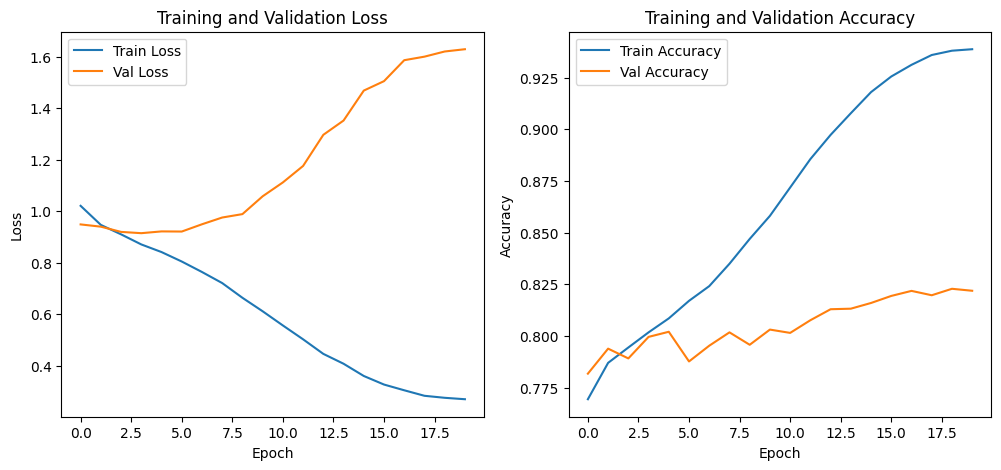

In [11]:
# Load EfficientNet-B3 with dropout
from torch.amp import GradScaler, autocast
model = models.efficientnet_b3(weights='EfficientNet_B3_Weights.IMAGENET1K_V1')
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.classifier[1].in_features, len(mlb.classes_))
)
model = model.to(device)
print(f"Model moved to {device}")

# Hyperparameters
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1 / (train_df[genre].mean() + 1e-6) for genre in mlb.classes_]).to(device))
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
scaler = GradScaler('cuda')


# Training loop with early stopping
num_epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_accuracy = 0
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.numel()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast('cuda'):
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
            preds = (outputs > 0.5).float()
            correct_val += (preds == labels).sum().item()
            total_val += labels.numel()

    val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    scheduler.step()

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('efficientnet_metrics_plot.png')
plt.show()

Model moved to cuda
Updated Thresholds: [ 0.2576   0.1039   0.4448   0.5713   0.3616   0.5728   0.4272   0.278
 -0.0114   2.055   -0.1092   0.03336]
Epoch 1/10, Train Loss: 1.0202, Val Loss: 0.9666, Train Accuracy: 0.7339, Val Accuracy: 0.7547
Epoch 2/10, Train Loss: 0.9434, Val Loss: 0.9322, Train Accuracy: 0.7444, Val Accuracy: 0.7609
Epoch 3/10, Train Loss: 0.9040, Val Loss: 0.9319, Train Accuracy: 0.7592, Val Accuracy: 0.7642
Epoch 4/10, Train Loss: 0.8712, Val Loss: 0.9171, Train Accuracy: 0.7690, Val Accuracy: 0.7529
Epoch 5/10, Train Loss: 0.8408, Val Loss: 0.9208, Train Accuracy: 0.7772, Val Accuracy: 0.7721
Epoch 6/10, Train Loss: 0.8033, Val Loss: 0.9090, Train Accuracy: 0.7889, Val Accuracy: 0.7701
Epoch 7/10, Train Loss: 0.7570, Val Loss: 0.9500, Train Accuracy: 0.8021, Val Accuracy: 0.7781
Epoch 8/10, Train Loss: 0.7109, Val Loss: 0.9586, Train Accuracy: 0.8145, Val Accuracy: 0.7816
Epoch 9/10, Train Loss: 0.6585, Val Loss: 1.0069, Train Accuracy: 0.8299, Val Accuracy: 0.7

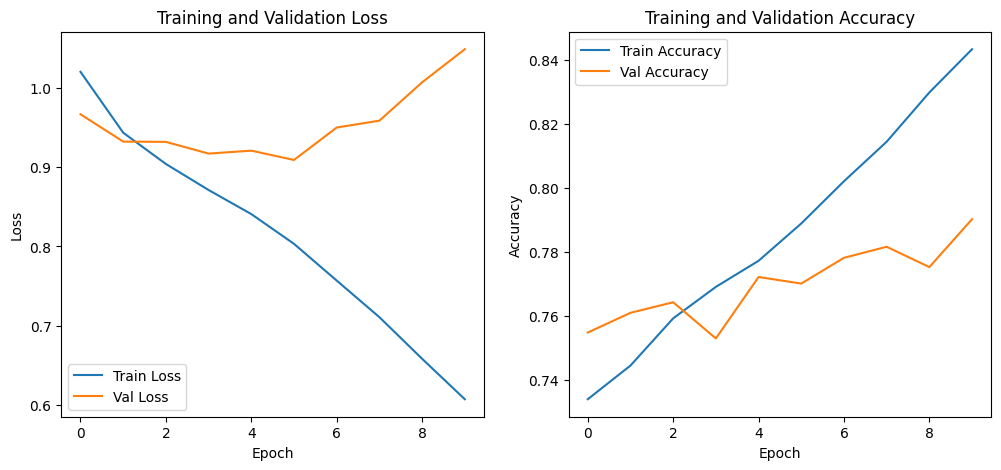

In [13]:
# Load EfficientNet-B3 with dropout
from torch.amp import GradScaler, autocast
model = models.efficientnet_b3(weights='EfficientNet_B3_Weights.IMAGENET1K_V1')
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.classifier[1].in_features, len(mlb.classes_))
)
model = model.to(device)
print(f"Model moved to {device}")

# Stronger class weights (capped to avoid instability)
class_frequencies = np.array([train_df[genre].mean() for genre in mlb.classes_])
pos_weights = torch.tensor(np.minimum(1 / (class_frequencies + 1e-6), 50.0)).to(device)  # Cap at 50
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
scaler = GradScaler('cuda')

# Per-genre thresholds (initialize at 0.3, update after first epoch)
thresholds = torch.tensor([0.3] * len(mlb.classes_)).to(device)

# Training loop with early stopping and debugging
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_accuracy = 0
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    train_pos_preds = torch.zeros(len(mlb.classes_)).to(device)

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

        preds = (outputs > thresholds).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.numel()
        train_pos_preds += preds.sum(dim=0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    # print(f"Train Positive Predictions per Genre: {train_pos_preds.cpu().numpy()}")

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_pos_preds = torch.zeros(len(mlb.classes_)).to(device)
    val_outputs = []
    val_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast('cuda'):
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
            preds = (outputs > thresholds).float()
            correct_val += (preds == labels).sum().item()
            total_val += labels.numel()
            val_pos_preds += preds.sum(dim=0)
            val_outputs.append(outputs)
            val_labels.append(labels)

    val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    # print(f"Val Positive Predictions per Genre: {val_pos_preds.cpu().numpy()}")

    # Update thresholds based on validation outputs (after first epoch)
    if epoch == 0:
        val_outputs = torch.cat(val_outputs, dim=0)
        val_labels = torch.cat(val_labels, dim=0)
        thresholds = []
        for i in range(len(mlb.classes_)):
            genre_outputs = val_outputs[:, i].cpu().numpy()
            genre_labels = val_labels[:, i].cpu().numpy()
            if genre_labels.sum() > 0:
                sorted_outputs = np.sort(genre_outputs[genre_labels == 1])
                threshold = sorted_outputs[int(0.3 * len(sorted_outputs))] if len(sorted_outputs) > 0 else 0.3
            else:
                threshold = 0.3
            thresholds.append(threshold)
        thresholds = torch.tensor(thresholds).to(device)
        print(f"Updated Thresholds: {thresholds.cpu().numpy()}")

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # # Early stopping
    # if val_accuracy > best_val_accuracy:
    #     best_val_accuracy = val_accuracy
    #     patience_counter = 0
    #     torch.save(model.state_dict(), 'best_model.pth')
    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         break

    scheduler.step()

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('efficientnet_metrics_plot.png')
plt.show()

#SINGLE LABEL GENRE CLASSIFICATION

In [14]:
from sklearn.preprocessing import LabelEncoder
# Drop rows where poster download failed
data = data.dropna(subset=['local_poster_path'])
print(f"After dropping failed downloads, dataset size: {len(data)}")

# Define valid genres
valid_genres = ['Drama', 'Comedy', 'Documentary', 'Romance', 'Action', 'Thriller',
                'Horror', 'Crime', 'Music', 'Animation', 'TV Movie', 'Family']

# Convert to single-label (take first genre)
data['single_genre'] = data['genres'].apply(lambda x: x[0] if len(x) > 0 and x[0] in valid_genres else None)
data = data.dropna(subset=['single_genre'])
print(f"After single-genre filtering, dataset size: {len(data)}")

# Encode single genre
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(valid_genres)  # Ensure consistent ordering
data['genre_label'] = label_encoder.transform(data['single_genre'])

# Balance classes (optional, to reduce imbalance)
genre_counts = data['single_genre'].value_counts()
min_count = genre_counts.min()  # Cap at minimum class size
balanced_data = []
for genre in valid_genres:
    # genre_data = data[data['single_genre'] == genre].sample(min(min_count, len(genre_counts[genre])), random_state=42)
    genre_data = data[data['single_genre'] == genre].sample(min(min_count, genre_counts[genre]), random_state=42)
    balanced_data.append(genre_data)
data = pd.concat(balanced_data).reset_index(drop=True)
print(f"After balancing classes, dataset size: {len(data)}")
print(f"Genre distribution:\n{data['single_genre'].value_counts(normalize=True)}")

# Split data
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['genre_label'])
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

# Check for data leakage
assert len(set(train_df['movie_id']).intersection(set(val_df['movie_id']))) == 0, "Data leakage detected!"

# Optimized data augmentation
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset
class MoviePosterDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['local_poster_path']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['genre_label']
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Data loaders
train_dataset = MoviePosterDataset(train_df, transform=train_transform)
val_dataset = MoviePosterDataset(val_df, transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=1)

After dropping failed downloads, dataset size: 20506
After single-genre filtering, dataset size: 20506
After balancing classes, dataset size: 4752
Genre distribution:
single_genre
Drama          0.083333
Comedy         0.083333
Documentary    0.083333
Romance        0.083333
Action         0.083333
Thriller       0.083333
Horror         0.083333
Crime          0.083333
Music          0.083333
Animation      0.083333
TV Movie       0.083333
Family         0.083333
Name: proportion, dtype: float64
Training samples: 3801, Validation samples: 951


Model moved to cuda
Epoch 1/20, Train Loss: 2.2040, Val Loss: 2.2037, Train Accuracy: 0.2373, Val Accuracy: 0.2482
Epoch 2/20, Train Loss: 2.0140, Val Loss: 2.0975, Train Accuracy: 0.3107, Val Accuracy: 0.2850
Epoch 3/20, Train Loss: 1.8432, Val Loss: 2.1239, Train Accuracy: 0.3738, Val Accuracy: 0.2776
Epoch 4/20, Train Loss: 1.6720, Val Loss: 2.1586, Train Accuracy: 0.4273, Val Accuracy: 0.2923
Epoch 5/20, Train Loss: 1.4473, Val Loss: 2.3333, Train Accuracy: 0.5059, Val Accuracy: 0.2955
Epoch 6/20, Train Loss: 1.2322, Val Loss: 2.5105, Train Accuracy: 0.5851, Val Accuracy: 0.2671
Epoch 7/20, Train Loss: 1.0051, Val Loss: 2.7531, Train Accuracy: 0.6701, Val Accuracy: 0.2650
Epoch 8/20, Train Loss: 0.7589, Val Loss: 3.1617, Train Accuracy: 0.7469, Val Accuracy: 0.2639
Epoch 9/20, Train Loss: 0.5593, Val Loss: 3.5269, Train Accuracy: 0.8116, Val Accuracy: 0.2723
Epoch 10/20, Train Loss: 0.4054, Val Loss: 3.6255, Train Accuracy: 0.8671, Val Accuracy: 0.2702
Epoch 11/20, Train Loss: 0.30

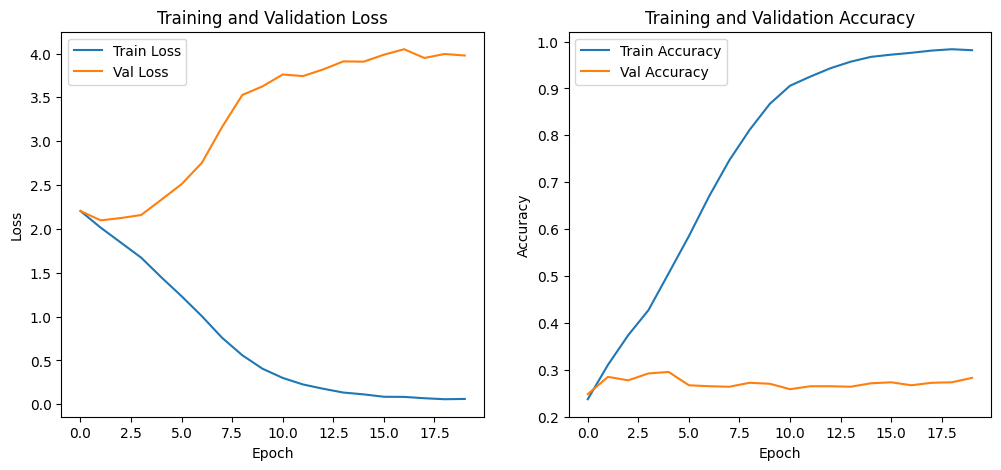

In [15]:
# Load EfficientNet-B3 with dropout
model = models.efficientnet_b3(weights='EfficientNet_B3_Weights.IMAGENET1K_V1')
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.classifier[1].in_features, len(valid_genres))
)
model = model.to(device)
print(f"Model moved to {device}")

# Hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
scaler = GradScaler('cuda')

# Training loop with early stopping
num_epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_accuracy = 0
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast('cuda'):
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
            preds = torch.argmax(outputs, dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # # Early stopping
    # if val_accuracy > best_val_accuracy:
    #     best_val_accuracy = val_accuracy
    #     patience_counter = 0
    #     torch.save(model.state_dict(), 'best_model.pth')
    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         break

    scheduler.step()

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('efficientnet_metrics_plot.png')
plt.show()